# AVISO data assimilation with correlated error reduction with 1-step approach

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import build_h_matrix, skill_matrix, inversion
from aviso_rossby_wave import build_swath, make_error
from aviso_rossby_wave import reverse_vector, forecast_ssh

## Starting Date

In [2]:
day0, day1 = 0, 1 # April 1st, 2017 # day0, day1 =  1856, 1857 July 1st, 2017
start_date = '2016-06-01' ## starting date
n_waves = '450' #number of waves

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east,  :]

In [5]:
T_time = avisso_ds.time.data[day0:] * 86400 # time in seconds
date_time = avisso_ds.date_time.data[day0:]
date_time[0], avisso_ds.msla.shape, SSHA.shape # longtitude, latitude, time

(numpy.datetime64('2016-06-01T00:00:00.000000000'),
 (104, 184, 150),
 (40, 40, 150))

In [6]:
ssha_time_mean = SSHA.mean(axis = -1)

In [7]:
SSHA = SSHA - SSHA.mean(axis = -1) - SSHA.mean(axis = 0)

In [8]:
SSHA_masked = np.ma.masked_invalid(SSHA)

In [9]:
ssha_mask = np.ma.getmask(SSHA_masked)

In [10]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

### Stratification paramters

In [11]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters to degrees
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

### Inversion with selecetd swath data points

In [12]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [13]:
Psi = strat_ds.Psi.data
MModes = 1
wavespeed = strat_ds.C2[:MModes].data  #np.array([Rm * f0])


### the aviso data is sampled at 5-day intervals

#### Rossby wave estimate

In [14]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date +'_' + n_waves + 'waves.nc')

#### Rossby deformation radius

In [15]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data

In [16]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [17]:
MSLA0 = MSLA_fwd[:, :, day0:day1]

In [18]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)
M = skill.size # number of models/waves

100%|████████████████████████████████████████| 450/450 [00:01<00:00, 249.28it/s]


In [19]:
kk, ll = np.meshgrid(k_n, l_n)

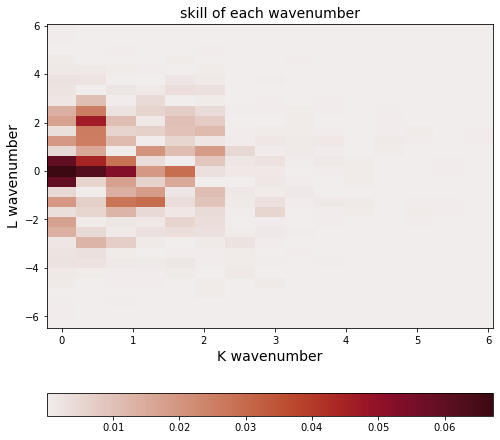

In [20]:
plt.figure(figsize = (8, 8))
plt.pcolor(kk, ll, skill[:, :, 0], cmap = cmo.cm.amp)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_KLwaves_' + str(M) + '.png')

#### Build basis function H matrix

In [21]:
MModes = 1
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
freq_n = np.zeros([M, MModes])

dlon = lon - lon.mean()
dlat = lat - lat.mean()

count = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            freq_n[count, mm] =  -1 * (Beta * k_n[kk]) / (k_n[kk] ** 2 + l_n[ll] ** 2 + Rm ** (-2))
            count += 1
nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])  
                H_sin[count, nn] = Psi[0, mm] * np.sin(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])
            nn += 1

In [22]:
#H_all[:, 0::2] = H_cos 
#H_all[:, 1::2] = H_sin

In [23]:
H_all = build_h_matrix(MSLA0, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm)

#### build satellite swath

In [24]:
swath_width, x_swath = 6, 20
days = np.arange(day0, day1) # np.array([0, 1]) #range(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

#### Add errors to the swaths

In [25]:
alpha_base = 1e-2 # baseline dialation error parameter
alpha_roll = -.5e-2 #  np.arange(1, len(day)) # roll error parameter
alpha_timing = .5e-7 # timing error parameter, set to be much smaller than others
alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6 = 4e-3, 3e-3, 2e-3, 1e-3
alpha = np.array([alpha_timing,  alpha_roll, alpha_base, alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6])
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, phase_err_left3, phase_err_left4, phase_err_left5, phase_err_left6, xc1_valid, xc2_valid  = make_error(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

In [26]:
 phase_err_left3.shape, baseline_dilation_err_valid.shape

((40, 6), (450,))

#### Add white noise 

In [27]:
IND_TIMING = -7
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [28]:
N = len(xvalid_index) # number of valid data points
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([N, 2 * M + 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
xc = (swath_width - 1) / 2

for ii in range(N):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[ii] =  cor_err[ii]  + ssh[ii] # + np.random.rand(1)/400
    # timing error = alpha[0] * Xc^0
    H_v[ii, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    H_v[ii, IND_ROLL] = xc1_valid[ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    H_v[ii, IND_BASELINE] = xc2_valid[ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) #
    H_pos = np.heaviside(xc1_valid[ii], 1) # 
    # print(H_neg, H_pos)
    H_v[ii, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    H_v[ii, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
    for nn in range(M):
        JIndex = 2 * MModes * nn
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

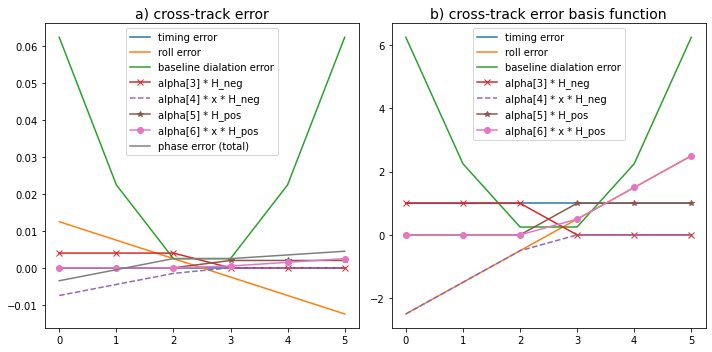

In [29]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.title('a) cross-track error', fontsize = 14)
plt.plot(timing_err_valid[:6], label = 'timing error')
plt.plot(roll_err_valid[:6], label = 'roll error')
plt.plot(baseline_dilation_err_valid[:6], label = 'baseline dialation error')
plt.plot(phase_err_left3[0, :6], '-x', label = 'alpha[3] * H_neg')
plt.plot(phase_err_left4[0, :6], '--', label = 'alpha[4] * x * H_neg')
plt.plot(phase_err_left5[0, :6], '-*', label = 'alpha[5] * H_pos')
plt.plot(phase_err_left6[0, :6], '-o', label = 'alpha[6] * x * H_pos')
plt.plot(phase_err_valid[:6], label = 'phase error (total)')
plt.legend()

plt.subplot(122)
plt.title('b) cross-track error basis function', fontsize = 14)
plt.plot(H_v[:6, IND_TIMING], label = 'timing error')
plt.plot(H_v[:6, IND_ROLL], label = 'roll error')
plt.plot(H_v[:6, IND_BASELINE], label = 'baseline dialation error')
#plt.plot(phase_err_valid[:6], label = 'phase error (total)')
plt.plot(H_v[:6, IND_PHASE3], '-x', label = 'alpha[3] * H_neg')
plt.plot(H_v[:6, IND_PHASE4], '--', label = 'alpha[4] * x * H_neg')
plt.plot(H_v[:6, IND_PHASE5], '-*', label = 'alpha[5] * H_pos')
plt.plot(H_v[:6, IND_PHASE6], '-o', label = 'alpha[6] * x * H_pos')
plt.legend()
plt.tight_layout()

plt.savefig('./cross_track_err_basis_function.png')

### 1-step approach: Solve for amplitudes and errors together

#### signal to noise ratio

In [30]:
counter = 0
exp = 1
alpha_factor = 1e1
kl = np.zeros(2 * M)
P_over_R = np.zeros([2 * M + 7, 2 * M + 7])
P_over_R[IND_TIMING, IND_TIMING] = alpha[IND_TIMING] * alpha_factor #** 2 # timing error
P_over_R[IND_ROLL, IND_ROLL] = alpha[IND_ROLL] ** 2 *  alpha_factor #** 2 # roll error
P_over_R[IND_BASELINE, IND_BASELINE] = alpha[IND_BASELINE]*  alpha_factor #** 2 # baseline dilation error
P_over_R[IND_PHASE3, IND_PHASE3] = alpha[IND_PHASE3] *  alpha_factor # ** 2 # phase error 1
P_over_R[IND_PHASE4, IND_PHASE4] = alpha[IND_PHASE4]* alpha_factor  # ** 2 # phase error 2
P_over_R[IND_PHASE5, IND_PHASE5] = alpha[IND_PHASE5] * alpha_factor # ** 2 # phase error 3
P_over_R[IND_PHASE6, IND_PHASE6] = alpha[IND_PHASE6]*  alpha_factor  # ** 2 # phase error 4

for kk in k_n:
    for ll in l_n:
        kl[counter] = np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        P_over_R[2 * counter, 2 * counter] = kl[counter] ** exp
        P_over_R[2 * counter+ 1, 2 * counter + 1] = kl[counter] ** exp
        counter += 1 

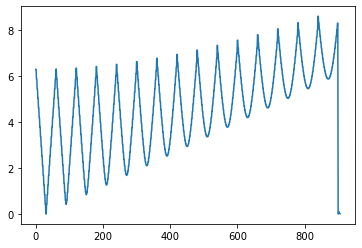

In [31]:
plt.plot(P_over_R.diagonal())

In [32]:
amp_1step, ssh_estimated_swath = inversion(Y_v, H_v, P_over_R)

#### One approach sanity check: fit errors to seven error basis functions

In [33]:
H_v[-7:, -7:].shape, P_over_R[-7:, -7:].shape

((7, 7), (7, 7))

In [34]:
amp_err_only, err_estimated_swath = inversion(cor_err, H_v[:, -7:], P_over_R[-7:, -7:])

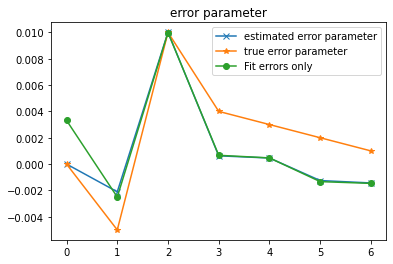

In [35]:
plt.title('error parameter')
plt.plot(amp_1step[-7:], '-x', label = 'estimated error parameter')
plt.plot(alpha, '-*' , label = 'true error parameter')
plt.plot(amp_err_only, '-o', label = 'Fit errors only')
plt.legend()
plt.savefig('err_parameter_7err.png')

In [36]:
amp_1step[-7:], alpha

(array([ 6.14130874e-07, -2.10712600e-03,  1.00102085e-02,  6.25446475e-04,
         4.60175635e-04, -1.25089295e-03, -1.43320505e-03]),
 array([ 5.e-08, -5.e-03,  1.e-02,  4.e-03,  3.e-03,  2.e-03,  1.e-03]))

In [37]:
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[ii] = ssh[ii] + cor_err[ii] # + np.random.rand(1)/400
    # timing error = alpha[0] * Xc^0
    H_v[ii, IND_TIMING] = 1 
    # roll error = alpha[1] * Xc^1
    H_v[ii, IND_ROLL] = xc1_valid[ii]
    # baseline dialation error = alpha[2] * Xc^2
    H_v[ii, IND_BASELINE] = xc2_valid[ii] 
    # phase error 
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1) 
    H_v[ii, IND_PHASE3] = H_neg                 
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v[ii, IND_PHASE5] = H_pos                 
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos
    
    for mm in range(M):
        JIndex = 2 * MModes * mm
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), mm]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), mm]

ssh_estimated_swath = np.matmul(H_v, amp_1step) # estimated swath SSH-1 *

In [38]:
from scipy.stats import norm
ssh_diff = ssh_estimated_swath - ssh
#print(norm.pdf(ssh_diff, ssh_diff.mean(), ssh_diff.std()))

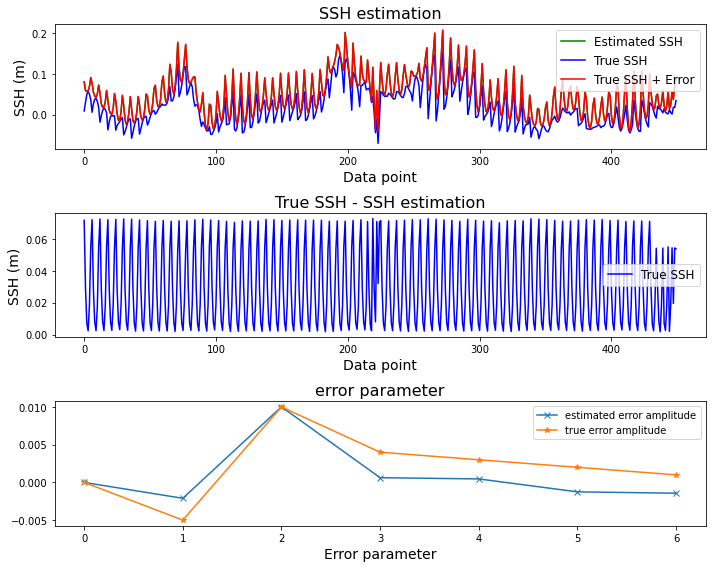

In [39]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(ssh_estimated_swath, 'green', label='Estimated SSH')
plt.plot(ssh, 'b', label='True SSH')
plt.plot(ssh + cor_err, 'r', label = 'True SSH + Error')
#plt.xlabel('Distance along swath (km)', fontsize=14)
plt.xlabel('Data point', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('SSH estimation', fontsize=16)
plt.legend(fontsize=12)
#plt.show()

plt.subplot(312)
#plt.plot(norm.pdf(ssh_diff, ssh_diff.mean(), ssh_diff.std()), '-', label='SSH difference')
plt.plot(ssh_diff, 'b', label='True SSH')
plt.xlabel('Data point', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('True SSH - SSH estimation', fontsize=16)
plt.legend(fontsize=12)

plt.subplot(313)
plt.title('error parameter', fontsize=16)
plt.plot(amp_1step[-7:], '-x', label = 'estimated error amplitude')
plt.plot(alpha, '-*', label = 'true error amplitude')
plt.xlabel('Error parameter', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('./ssh_err_parameter.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


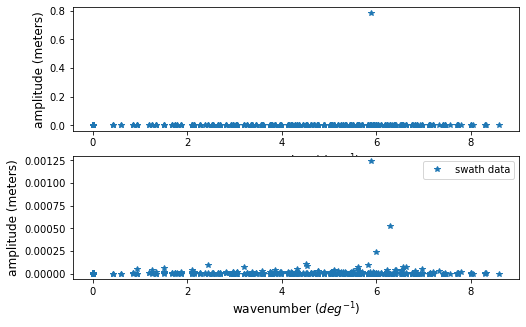

In [40]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step[:-7] ** 2  , '*', label = 'true amp')
plt.subplot(212)
plt.legend()

plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'swath data')
plt.legend()

#### True and estimated SSH and Errors

In [41]:
Y_hat = np.matmul(H_v, amp_1step)
err_est = np.matmul(H_v[:, -7:], amp_1step[-7:])
ssh_est = np.matmul(H_v[:, :-7], amp_1step[:-7])
err_map1 = np.zeros([len(lon), len(lat)])
ssh_map1 = np.zeros([len(lon), len(lat)])
ssh_true1 = np.zeros([len(lon), len(lat)])
err_true1 = np.zeros([len(lon), len(lat)])
for ii, idx in enumerate(xvalid_index):
    err_map1[xvalid_index[ii], yvalid_index[ii]] = err_est[ii] 
    ssh_map1[xvalid_index[ii], yvalid_index[ii]]  = ssh_est[ii]
    err_true1[xvalid_index[ii], yvalid_index[ii]] = cor_err[ii]
    ssh_true1[xvalid_index[ii], yvalid_index[ii]] = ssh[ii]

#### Reverse the vectorization on the swaths

In [42]:
ssh_diff1 = np.sqrt(np.mean((ssh_true1 - ssh_map1) ** 2 ))/ np.sqrt(np.mean((ssh_true1) ** 2 ))

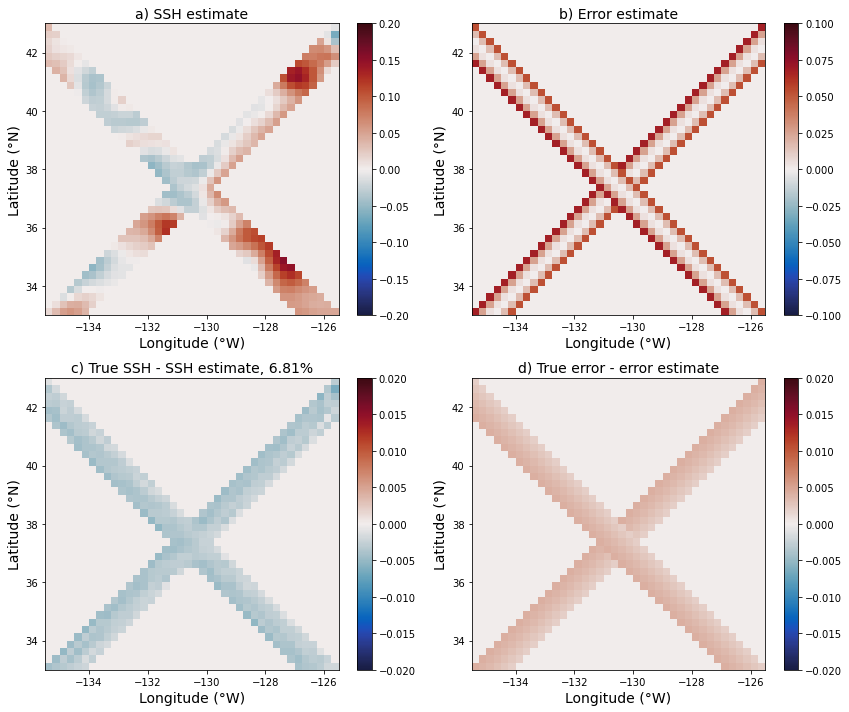

In [91]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_map1, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(222)
plt.pcolormesh(lon, lat, err_map1, cmap = cmo.cm.balance, vmin = -.1, vmax = .1)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) Error estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true1 - ssh_map1, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff1 * 100)[:4] + '%', fontsize = 14)

plt.subplot(224)
plt.pcolormesh(lon, lat, err_true1 - err_map1, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) True error - error estimate', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(date_time[0])[:10] + '_1step.png', dpi = 300)

#### Make predictions of SSH based on the estimated amplitudes:
#### is the extrapolation skill good?

In [92]:
MSLA0.shape

(40, 40, 1)

2016-06-01T00:00:00.000000000
2016-06-06T00:00:00.000000000
2016-06-11T00:00:00.000000000
2016-06-16T00:00:00.000000000
2016-06-21T00:00:00.000000000
2016-06-26T00:00:00.000000000
2016-07-01T00:00:00.000000000
2016-07-06T00:00:00.000000000


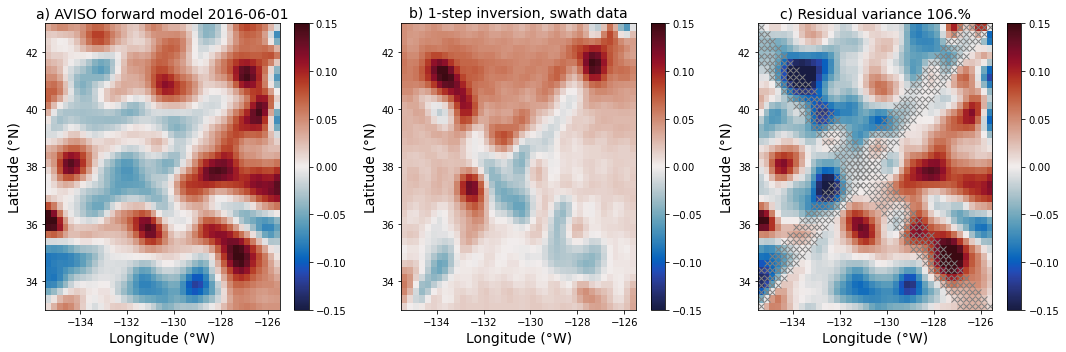

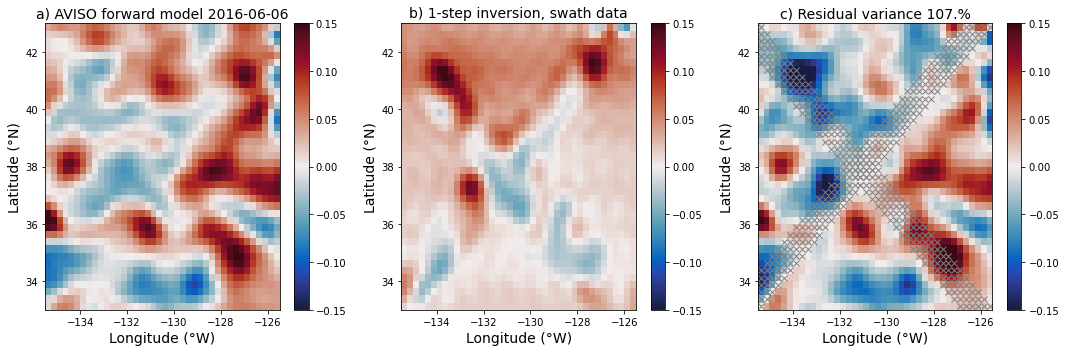

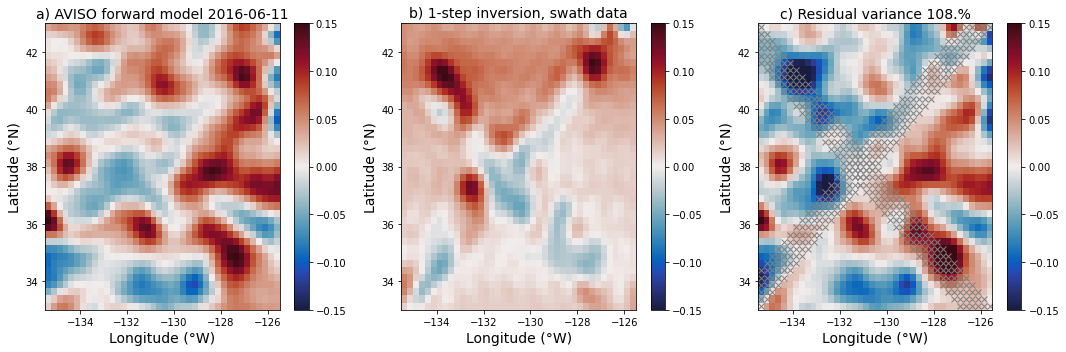

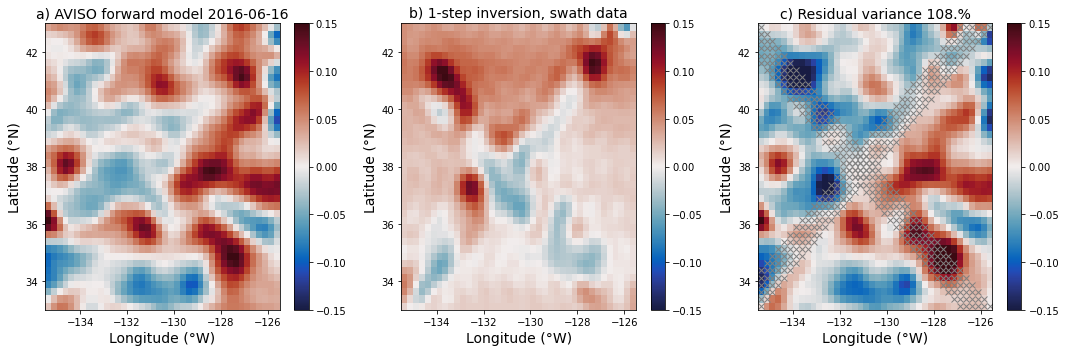

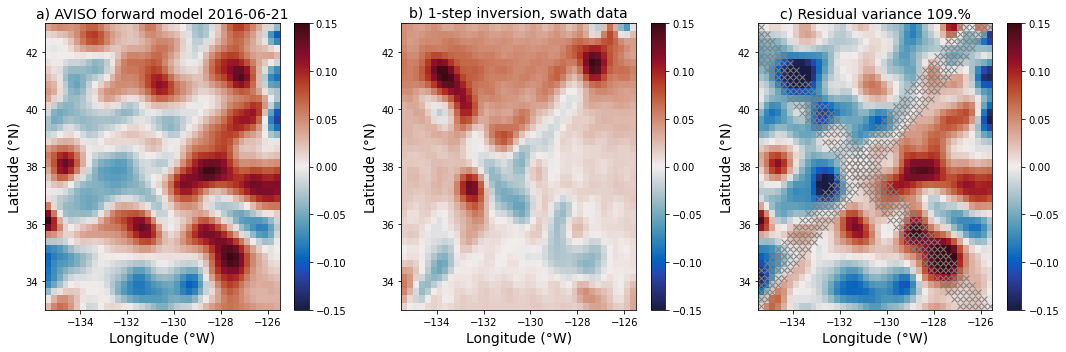

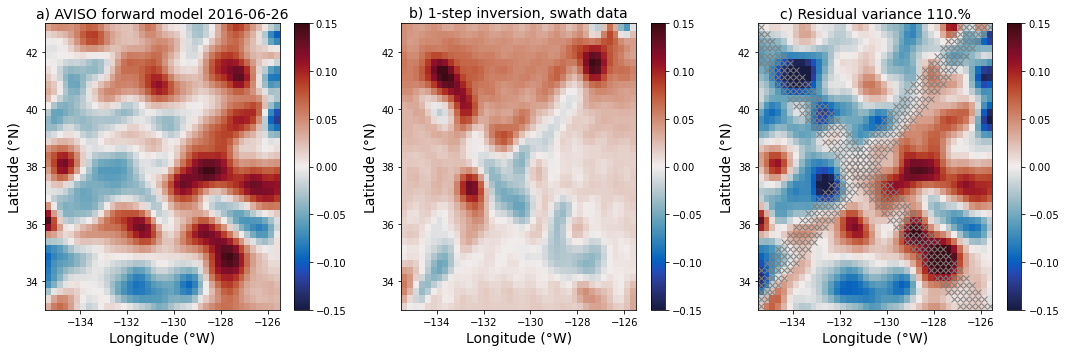

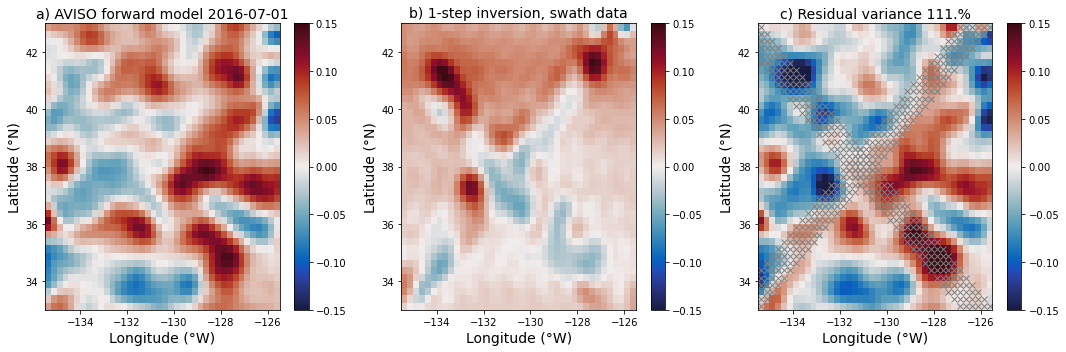

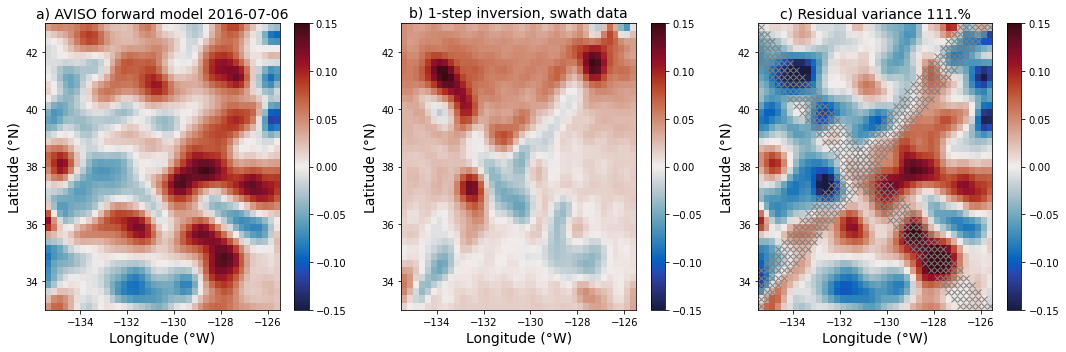

In [90]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
residual_iter = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range):
    print(date_time[day])
    MSLA = MSLA_fwd[:,:,day:day+1] 
    SSHA_predicted[day], SSHA_true[day], residual_iter[day] = forecast_ssh(day, amp_1step[:-7], MSLA, H_all, T_time)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    #plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, swath data', fontsize = 14)

    residual = MSLA[:, :, 0] - MSLA_inverse[:, :, day] 
    plt.subplot(133)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' +  str(residual_iter[day] * 100)[:4] + '%', fontsize = 14)
    
    plt.tight_layout()
    #plt.close()
    plt.savefig('ssh_1step_' + str(date_time[day])[:10] +'_2_err_' + str(skill.size) + 'waves.png', dpi = 300)
    

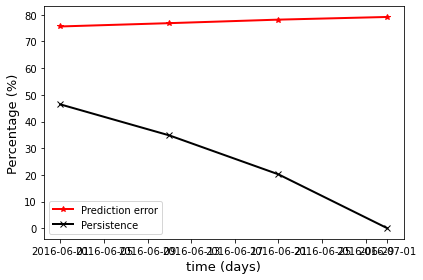

In [45]:
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0+6:day0+7]
prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
rms_persistence = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    #rms_persistence_err[t] = np.sqrt(np.mean(persistence_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, t].data ** 2))

#plt.figure(figsize = (10,10))
#plt.subplot(211)
plt.plot(time[:time_range][0::2],  rms_prediction_err[:time_range][0::2] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Prediction error')

#plt.subplot(212)
plt.plot(time[:time_range][0::2], rms_persistence[:time_range][0::2] * 100,  
         '-x', linewidth = 2, color = 'k', label = 'Persistence' )
#plt.plot(T_time[:time_range][0::2]/86400, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
#plt.xticks(time[:time_range][0::2]/86400, time[:time_range][0::2] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time (days)', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/prediction_err_vs_persistence_' + str(M) + '_waves_2errs.png', dpi = 300)

### One approach sanity check: fit errors to seven error basis functions

#### construct H matrix with only error basis funcstons

In [46]:
count = 0
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v1 = np.zeros([N, 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
Y_v, cor_err, ssh = np.zeros(N), np.zeros(N), np.zeros(N)
for ii in range(len(xvalid_index)):
    #IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    
    # Only fit errors! 
    Y_v[ii] =  cor_err[ii]  #+ ssh[ii]  #
    
    H_v1[ii, IND_TIMING] = 1 # timing error = alpha[0] * X^0 
    H_v1[ii, IND_ROLL] = xc1_valid[ii] # roll error = alpha[1] * X^1
    H_v1[ii, IND_BASELINE] = xc2_valid[ii] # baseline dialation error = alpha[2] * X^2
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1)
    
    # phase error
    H_v1[ii, IND_PHASE3] = H_neg                 
    H_v1[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v1[ii, IND_PHASE5] = H_pos                 
    H_v1[ii, IND_PHASE6] = xc1_valid[ii] * H_pos 

In [47]:
P_over_R1 = np.eye(7, 7)
P_over_R1[IND_TIMING, IND_TIMING] = alpha[IND_TIMING] * alpha_factor #** 2 # timing error
P_over_R1[IND_ROLL, IND_ROLL] = alpha[IND_ROLL] *  alpha_factor #** 2 # roll error
P_over_R1[IND_BASELINE, IND_BASELINE] = alpha[IND_BASELINE]*  alpha_factor #** 2 # baseline dilation error
P_over_R1[IND_PHASE3, IND_PHASE3] = alpha[IND_PHASE3] *  alpha_factor #** 2 # phase error 1
P_over_R1[IND_PHASE4, IND_PHASE4] = alpha[IND_PHASE4]*  alpha_factor  #** 2 # phase error 2
P_over_R1[IND_PHASE5, IND_PHASE5] = alpha[IND_PHASE5] *  alpha_factor #** 2 # phase error 3
P_over_R1[IND_PHASE6, IND_PHASE6] = alpha[IND_PHASE6]*  alpha_factor  #** 2 # phase error 4

In [48]:
HTH = np.matmul(H_v1.T, H_v1)

In [49]:
HRH = HTH + P_over_R1 #0.81 * sigma #, P: uncertainty in model, R: uncertainty in data
D = np.matmul(LA.inv(HRH), H_v1.T)   

In [50]:
amp_err = np.matmul(D, Y_v)
amp_err , alpha

(array([ 0.00332977,  0.01001319,  0.00999662,  0.00066802, -0.01202119,
        -0.00133595, -0.01400239]),
 array([ 5.e-08, -5.e-03,  1.e-02,  4.e-03,  3.e-03,  2.e-03,  1.e-03]))

In [51]:
#### test: fit two errors with two error models
amp_2err_2model = np.matmul(D, cor_err)
amp_2err_2model ,  alpha

(array([ 0.00332977,  0.01001319,  0.00999662,  0.00066802, -0.01202119,
        -0.00133595, -0.01400239]),
 array([ 5.e-08, -5.e-03,  1.e-02,  4.e-03,  3.e-03,  2.e-03,  1.e-03]))

#### correlated error estimate

In [52]:
#### estimate the correlated error
err_est = np.matmul(H_v1, amp_err)
#err_est

#### SSH + correlated errors - estimated correlated errors

In [53]:
tau_ssh = Y_v - err_est

In [54]:
err_map = np.zeros([len(lon), len(lat)])
ssh_true = np.zeros([len(lon), len(lat)])
ssh_1st_step = np.zeros([len(lon), len(lat)])
err_true = np.zeros([len(lon), len(lat)])
for ii, idx in enumerate(xvalid_index):
    err_map[yvalid_index[ii], xvalid_index[ii]] = err_est[ii] #[Iindex[ii].astype(int)]
    ssh_true[yvalid_index[ii], xvalid_index[ii]] = ssh[ii]
    err_true[yvalid_index[ii], xvalid_index[ii]] = cor_err[ii]
    ssh_1st_step[yvalid_index[ii], xvalid_index[ii]] = tau_ssh[ii]

In [55]:
ssh_diff_1st_step = np.sqrt(np.mean((ssh_true - ssh_1st_step) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))
ssh_diff_1st_step , str(ssh_diff_1st_step * 100)[:4] 

(1.0000031437881296, '100.')

In [56]:
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[ii] =  cor_err[ii] # + ssh[ii] + # + np.random.rand(1)/400
    H_v1[ii, IND_TIMING] = 1 
    H_v1[ii, IND_BASELINE] = xc1_valid[ii] 
    H_v1[ii, IND_ROLL] = xc2_valid[ii] 
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1) 
    H_v[ii, IND_PHASE3] = H_neg                 
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v[ii, IND_PHASE5] = H_pos                 
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos 
    
    for nn in range(M):
        JIndex = 2 * MModes * nn
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

#ssh_estimated_swath = np.matmul( H_v1, err_est) # estimated swath SSH

###  Ambiguity test 

#### basis function correlation matrix: assessing whether the basis functions are orthogonal

In [57]:
import pandas as pd
import seaborn as sns
# collect data
data = H_v[:, -7:]
# form dataframe
dataframe = pd.DataFrame(data, columns=['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
cov_matrix = dataframe.cov()

In [58]:
corr_matrix = dataframe.corr()

In [59]:
H_v[:, -7:].shape, cov_matrix

((450, 7),
         TIMING          ROLL          BASE        PHASE3    PHASE4  \
 TIMING     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000   
 ROLL       0.0  2.923163e+00 -4.945314e-19 -7.516704e-01  1.461581   
 BASE       0.0 -4.945314e-19  6.236080e+00 -9.890628e-19 -1.002227   
 PHASE3     0.0 -7.516704e-01 -9.890628e-19  2.505568e-01 -0.375835   
 PHASE4     0.0  1.461581e+00 -1.002227e+00 -3.758352e-01  0.897829   
 PHASE5     0.0  7.516704e-01  9.890628e-19 -2.505568e-01  0.375835   
 PHASE6     0.0  1.461581e+00  1.002227e+00 -3.758352e-01  0.563753   
 
               PHASE5    PHASE6  
 TIMING  0.000000e+00  0.000000  
 ROLL    7.516704e-01  1.461581  
 BASE    9.890628e-19  1.002227  
 PHASE3 -2.505568e-01 -0.375835  
 PHASE4  3.758352e-01  0.563753  
 PHASE5  2.505568e-01  0.375835  
 PHASE6  3.758352e-01  0.897829  )

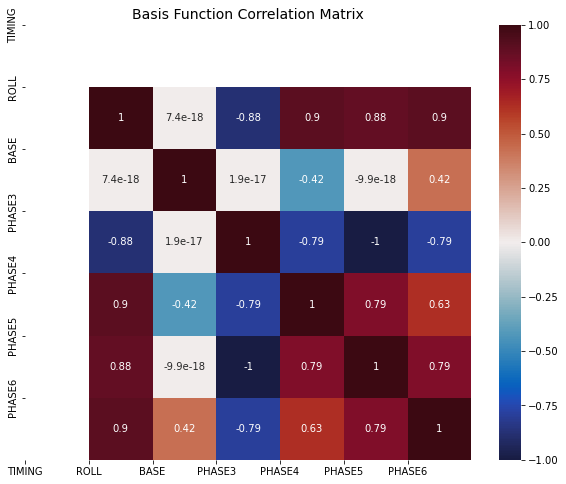

In [60]:
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = cmo.cm.balance, vmin = -1, vmax = 1)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.title('Basis Function Correlation Matrix', fontsize = 14)
plt.savefig('./H_corr_matrix.png')

#### the proterier covariance matrix of the difference between the estimated and the true model parameters is

In [61]:
COV = LA.inv(HRH + LA.inv(P_over_R1))

In [62]:
def correlation_from_covariance(covariance):
    
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    
    return correlation

In [63]:
COR = correlation_from_covariance(COV)

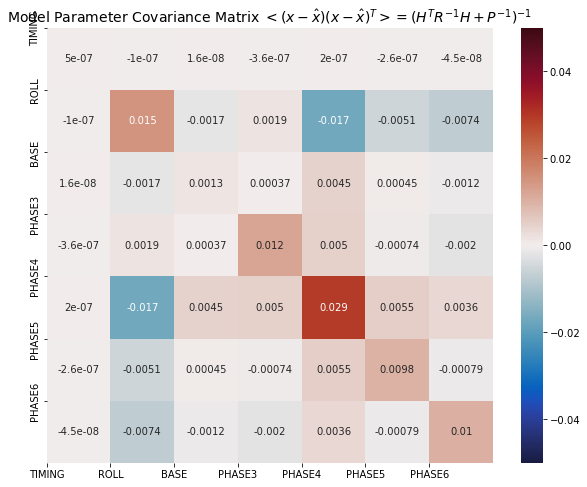

In [64]:
plt.figure(figsize = (10, 8))
sns.heatmap(COV, annot = True, cmap = cmo.cm.balance, vmin = -.05, vmax = .05)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.title('Model Parameter Covariance Matrix $<(x-\hat{x})(x-\hat{x})^T> = (H^{T}R^{-1}H + P^{-1})^{-1}$', fontsize = 14)
plt.savefig('./cov_matrix.png')

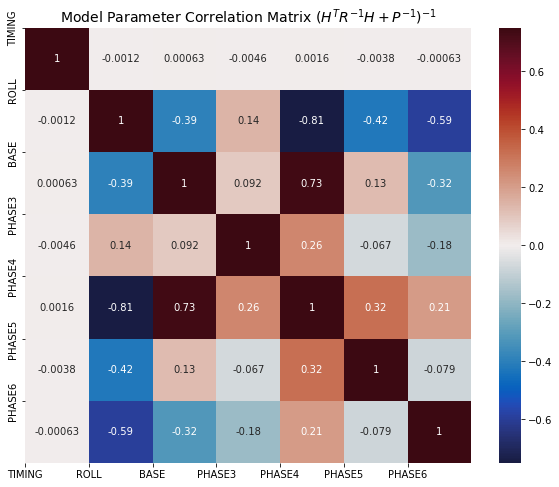

In [65]:
plt.figure(figsize = (10, 8))
sns.heatmap(COR, annot = True, cmap = cmo.cm.balance, vmin = -.75, vmax = .75)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.title('Model Parameter Correlation Matrix $(H^{T}R^{-1}H + P^{-1})^{-1}$', fontsize = 14)
plt.savefig('./corr_matrix.png')

### Two-step approach: reconstructing the SSH separately from solving the correlated error

#### First step: fit errors

In [66]:
count = 0
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v1 = np.zeros([N, 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
Y_v, cor_err, ssh = np.zeros(N), np.zeros(N), np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    cor_err[ii] = roll_err_valid[ii] + baseline_dilation_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[ii] =  cor_err[ii] + ssh[ii] # + np.random.rand(1)/10 
    H_v1[ii, IND_TIMING] = 1 
    H_v1[ii, IND_BASELINE] = xc1_valid[ii] 
    H_v1[ii, IND_ROLL] = xc2_valid[ii] 
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1) 
    H_v[ii, IND_PHASE3] = H_neg                 
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v[ii, IND_PHASE5] = H_pos                 
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos 
    #H_v1[ii, -1] = xc1_valid[ii] #/ xc1_valid.max() # ROLL ERR, distance from nadir Xc !!! Normalized
    #H_v1[ii, -2] = xc2_valid[ii] #/ xc2_valid.max() # BASELINE DIALATION ERR, distance from nadir Xc !!! Normalized

In [67]:
P_over_R1 = P_over_R[-7:, -7:]

In [68]:
HTH = np.matmul(H_v1.T, H_v1)

In [69]:
HRH = HTH + P_over_R1 #0.81 * sigma #, P: uncertainty in model, R: uncertainty in data
D = np.matmul(LA.inv(HRH), H_v1.T)   

In [70]:
amp_err = np.matmul(D, Y_v)
amp_err[-7:] , alpha
#plt.plot(amp_err[-7:]) 
#plt.plot(alpha)

(array([0.01735511, 0.00988222, 0.00201196, 0.        , 0.        ,
        0.        , 0.        ]),
 array([ 5.e-08, -5.e-03,  1.e-02,  4.e-03,  3.e-03,  2.e-03,  1.e-03]))

In [71]:
#### test: fit two errors with two error models
amp_2err_2model = np.matmul(D, cor_err)
#plt.plot(amp_2err_2model) 
#plt.plot(alpha)

#### correlated error estimate

In [72]:
#### estimate the correlated error
err_est = np.matmul(H_v1, amp_err)

#### SSH + correlated errors - estimated correlated errors

In [73]:
tau_ssh = Y_v - err_est

In [74]:
err_map = np.zeros([nx, ny])
ssh_true = np.zeros([nx, ny])
ssh_1st_step = np.zeros([nx, ny])
err_true = np.zeros([nx, ny])
for ii, idx in enumerate(xvalid_index):
    err_map[xvalid_index[ii], yvalid_index[ii]] = err_est[ii] #[Iindex[ii].astype(int)]
    ssh_true[xvalid_index[ii], yvalid_index[ii]] = ssh[ii]
    err_true[xvalid_index[ii], yvalid_index[ii]] = cor_err[ii]
    ssh_1st_step[xvalid_index[ii], yvalid_index[ii]] = tau_ssh[ii]

In [75]:
ssh_diff_1st_step = np.sqrt(np.mean((ssh_true - ssh_1st_step) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))
ssh_diff_1st_step , str(ssh_diff_1st_step * 100)[:4] 

(0.4260648697747139, '42.6')

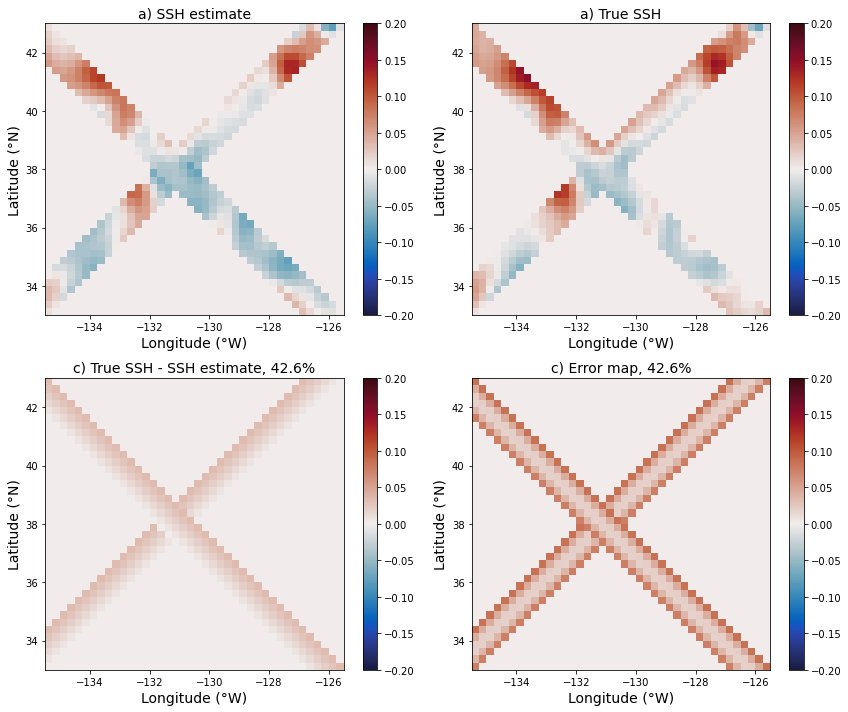

In [76]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_1st_step.T, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)


plt.subplot(222)
plt.pcolormesh(lon, lat, ssh_true.T, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True SSH', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true.T - ssh_1st_step.T, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff_1st_step * 100)[:4] + '%', fontsize = 14)


plt.subplot(224)
plt.pcolormesh(lon, lat, err_map.T , cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) Error map, ' + str(ssh_diff_1st_step * 100)[:4] + '%', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_err_map_1st_step.png')

#### second step: fit residual to rossby wave models

In [77]:
count = 0
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([N, 2 * M ]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    for nn in range(M):
        JIndex = 2 * MModes * nn #+  2 * mm # Model space
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

In [78]:
HTH = np.matmul(H_v.T, H_v)

In [79]:
RR, PP = 10, 1
R_ = np.eye(N, N)
R_over_P = P_over_R[:2 * M, :2 * M]

In [80]:
HRH = np.zeros(HTH.shape)
HRH = HTH +  R_over_P 

In [81]:
D = np.matmul(LA.inv(HRH), H_v.T)
eig, vec = LA.eig(HRH)

#### Soution with noise, 2 step approach

In [82]:
amp_swath_2step = np.matmul(D, tau_ssh)

#### Prediction with new amplitudes in the next 40 days

In [83]:
ssh_est = np.matmul(H_v, amp_swath_2step)

In [84]:
err_map = np.zeros([nx, ny])
ssh_true = np.zeros([nx, ny])
ssh_1st_step = np.zeros([nx, ny])
err_true = np.zeros([nx, ny])
for ii, idx in enumerate(xvalid_index):
    err_map[xvalid_index[ii], yvalid_index[ii]] = err_est[ii] 
    ssh_true[xvalid_index[ii], yvalid_index[ii]] = ssh_est[ii]
    err_true[xvalid_index[ii], yvalid_index[ii]] = cor_err[ii]
    ssh_1st_step[xvalid_index[ii], yvalid_index[ii]] = tau_ssh[ii]

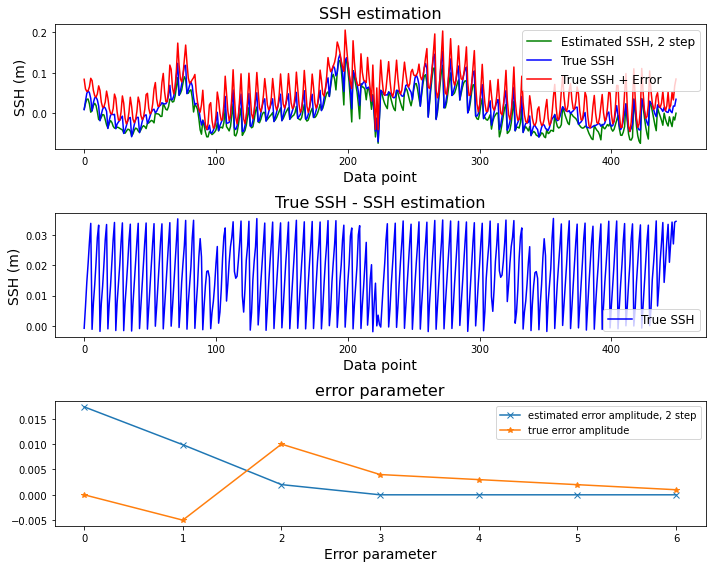

In [85]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(ssh_est, 'green', label='Estimated SSH, 2 step')
plt.plot(ssh, 'b', label='True SSH')
plt.plot(ssh + cor_err, 'r', label = 'True SSH + Error')
plt.xlabel('Data point', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('SSH estimation', fontsize=16)
plt.legend(fontsize=12)

ssh_diff = ssh - ssh_est

plt.subplot(312)
#plt.plot(norm.pdf(ssh_diff, ssh_diff.mean(), ssh_diff.std()), '-', label='SSH difference')
plt.plot(ssh_diff, 'b', label='True SSH')
plt.xlabel('Data point', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('True SSH - SSH estimation', fontsize=16)
plt.legend(fontsize=12)

plt.subplot(313)
plt.title('error parameter', fontsize=16)
plt.plot(amp_err, '-x', label = 'estimated error amplitude, 2 step')
plt.plot(alpha, '-*', label = 'true error amplitude')
plt.xlabel('Error parameter', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('./ssh_err_parameter_2step.png')

In [86]:
ssh_diff_1st_step = np.sqrt(np.mean((ssh_true - ssh_1st_step) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))
ssh_diff_1st_step , str(ssh_diff_1st_step * 100)[:4] 

(0.04959361333906914, '4.95')

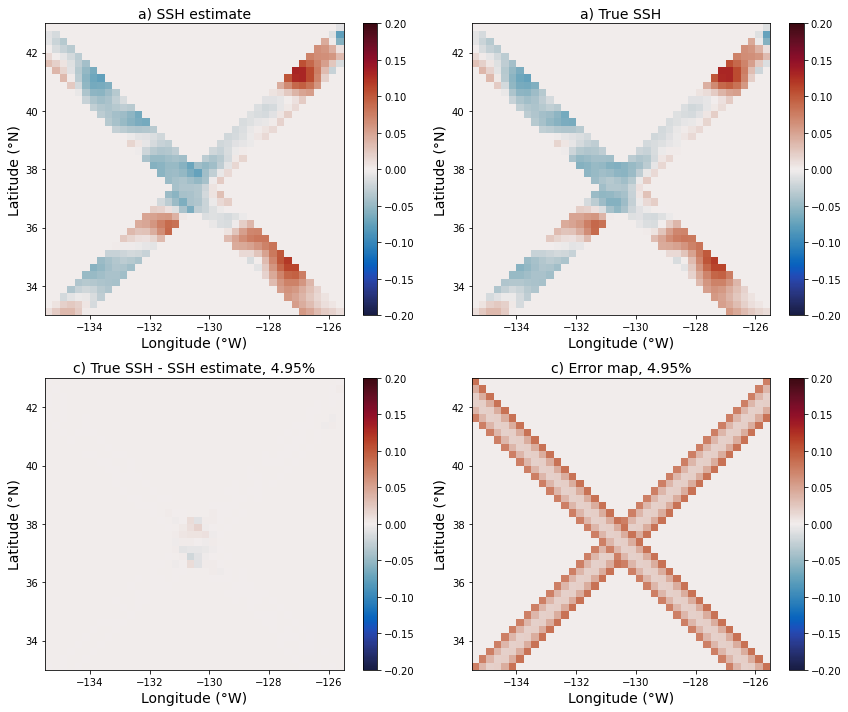

In [87]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_1st_step, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)


plt.subplot(222)
plt.pcolormesh(lon, lat, ssh_true, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True SSH', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true - ssh_1st_step, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff_1st_step * 100)[:4] + '%', fontsize = 14)


plt.subplot(224)
plt.pcolormesh(lon, lat, err_map , cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) Error map, ' + str(ssh_diff_1st_step * 100)[:4] + '%', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_err_map_2nd_step.png')

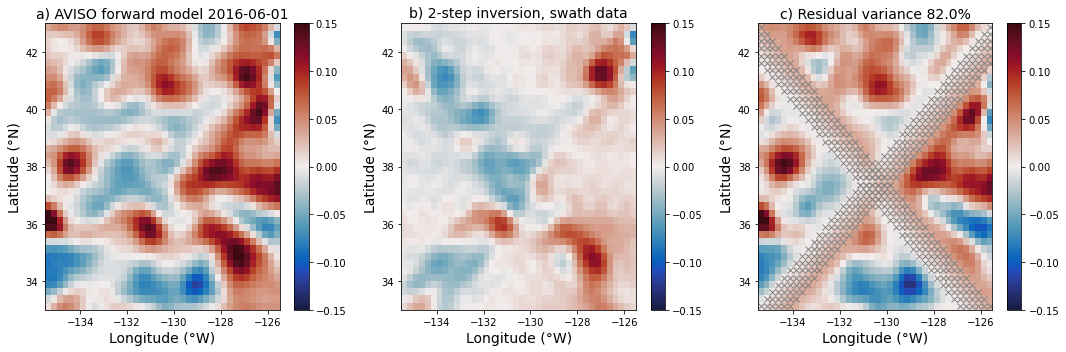

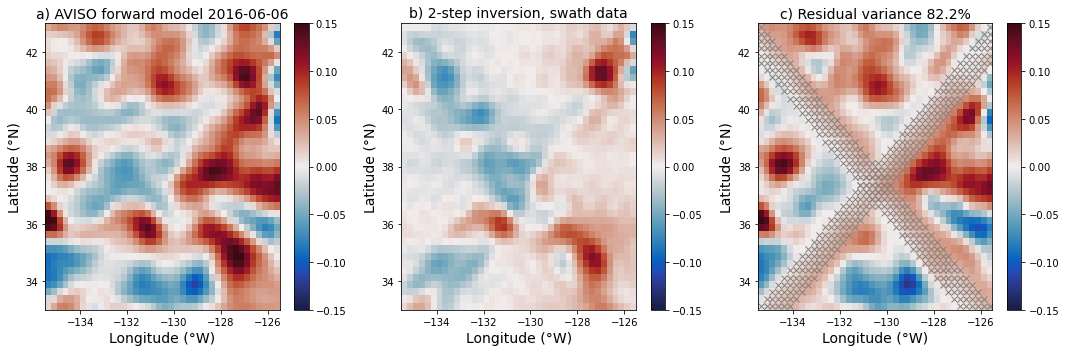

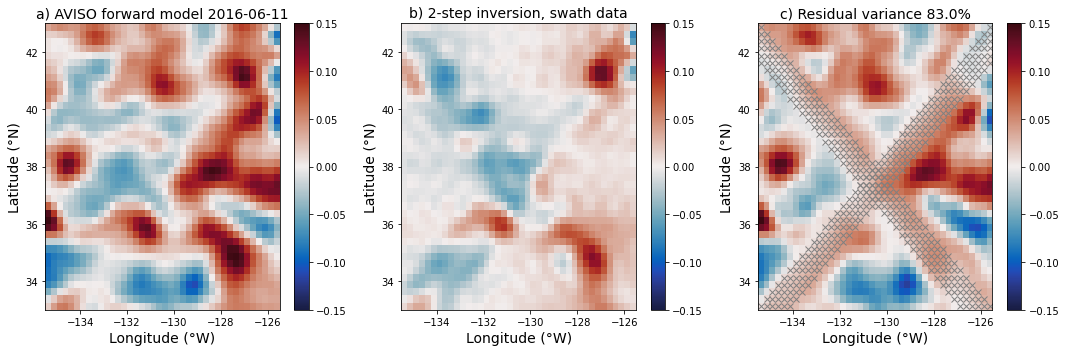

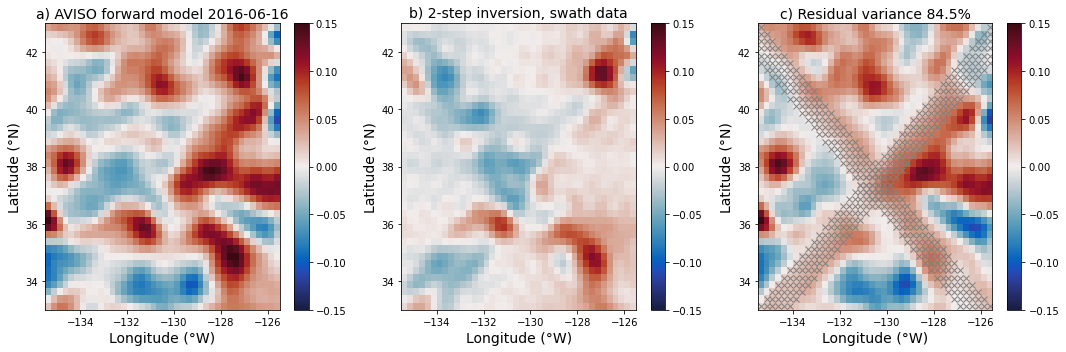

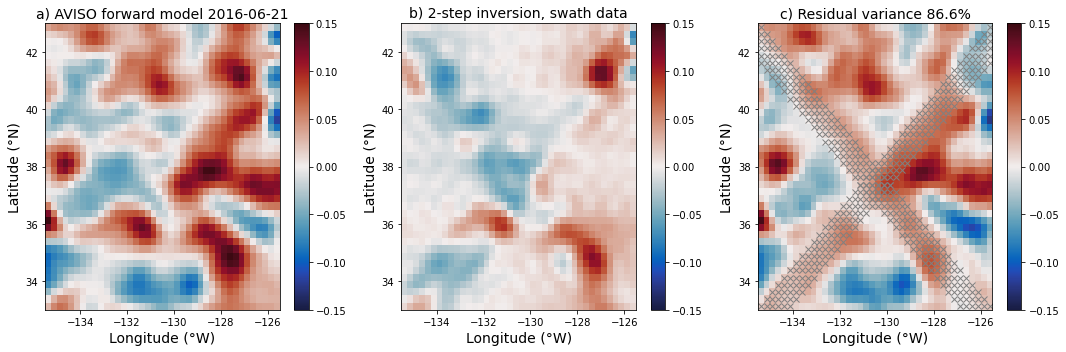

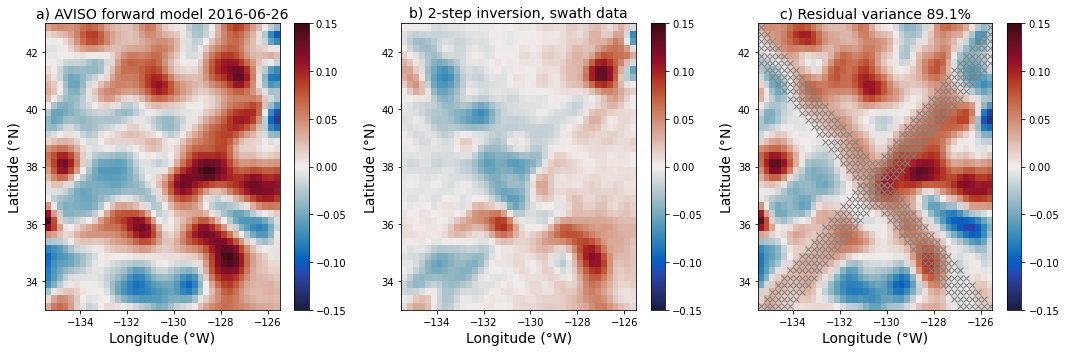

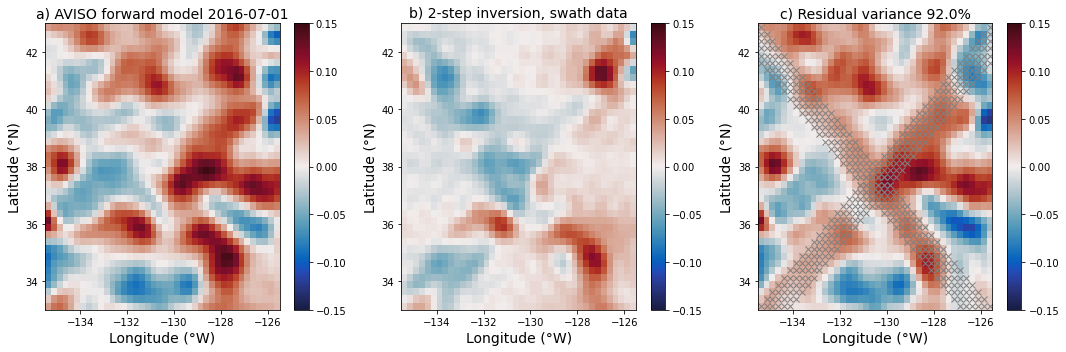

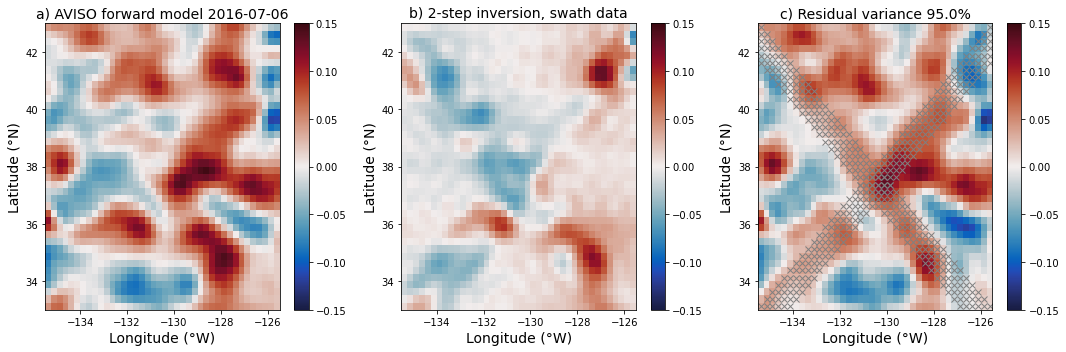

In [88]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA.size])
SSHA_true = np.zeros([time_range, MSLA.size])
residual_iter = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA.shape[0], MSLA.shape[1], time_range])
for day in range(time_range):
    MSLA = MSLA_fwd[:, :, day:day+1]
    SSHA_predicted[day], SSHA_true[day], residual_iter[day] = forecast_ssh(day, amp_swath_2step, MSLA, H_all, T_time)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA_fwd[:, :, day], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 2-step inversion, swath data', fontsize = 14)

    residual =   MSLA_fwd[:, :, day] - MSLA_inverse[:, :, day]
    plt.subplot(133)
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.plot(lon[yvalid_index], lat[xvalid_index], 'x', color = 'gray')
    plt.title('c) Residual variance ' + str(residual_iter[day] * 100)[:4] + '%', fontsize = 14)

    plt.tight_layout()
    plt.savefig('P_R_ratio' + str(P_over_R[0, 0]) + 'inversion_' + str(date_time[day])[:10] +'_with_corr_err_' + str(skill.size) + 'waves_2step.png', dpi = 100)